In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import h5py
import scipy
from sklearn.model_selection import KFold
from scipy import ndimage
from sklearn import metrics
from lifelines.utils import concordance_index
from pycox.evaluation import EvalSurv


from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as k
from sklearn.preprocessing import normalize
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import *
from pycox.preprocessing.label_transforms import LabTransDiscreteTime

import os
import tensorflow as tf

np.random.seed(1234)

## importing the datasets
data = pd.read_excel("Cancer.xlsx")


## Dealing with Missing values

data['meal.cal'].fillna(data['meal.cal'].mean(), inplace=True)
data['wt.loss'].fillna(data['wt.loss'].mean(), inplace=True)
data = data.dropna()    

features_cat = ["sex", "ph.ecog"]
features_con = ["age", "ph.karno", "pat.karno", 'meal.cal', 'wt.loss']

df_dummy = [pd.get_dummies(data['sex'], prefix = 'sex', prefix_sep = ':'), 
           pd.get_dummies(data["ph.ecog"], prefix = "ph.ecog", prefix_sep = ':')]

df_dummy = pd.concat(df_dummy, axis = 1)

data_combine = pd.concat([data, df_dummy], axis = 1)

features = df_dummy.columns.to_list() + features_con
data_feat = data_combine[["time", "status"] + features]


################# Spliting the dataset
data["status"] = data["status"].apply(lambda x:1 if x==2 else 0)

X = data_feat.drop(["status", "time"], axis = 1)
y = data_feat[["status", "time"]]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train = pd.concat([X_train, y_train], axis = 1).reset_index(drop = True)
test = pd.concat([X_test, y_test], axis = 1).reset_index(drop = True)



### Exporting the data

## This was the SSMTL data format used to build the DEEP learnng algorithm
## Export and show your supervisor via excel

train.to_csv("cancer_train_data_py.csv")  
test.to_csv("cancer_test_data_py.csv")   

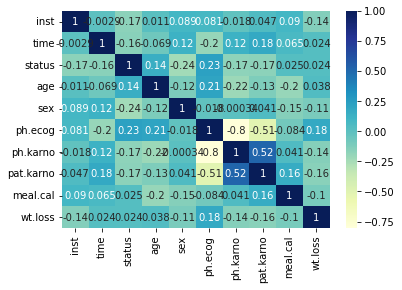

In [2]:
# The Correlation of the features

sns.heatmap(data.corr(), annot = True, cmap = "YlGnBu")
tf.random.set_seed(2020)

In [3]:
df_train = pd.read_csv("cancer_train_data_py.csv", index_col= 0)
df_test = pd.read_csv("cancer_test_data_py.csv",index_col= 0)

#df_test = pd.read_csv("Birth Control.csv",index_col= 0)


## Performing OneHotEncoding
df_train["status"] = df_train["status"].apply(lambda x:1 if x==2 else 0)
df_test["status"] = df_test["status"].apply(lambda x:1 if x==2 else 0)

In [4]:
get_x = lambda df: (df.drop(columns=['time', 'status']).values.astype('float32'))
x_train = get_x(df_train)
x_test = get_x(df_test)

In [5]:
def get_y_labels(status, time):
    ret = np.ones((status.shape[0], np.max(time) + 1)) 
    for i in range(status.shape[0]):
        if status[i] == 1:
            ret[i, 0:time[i] - 1 + 1] = 0
        elif status[i] == 0:
            ret[i, 0:time[i] + 1] = 0
            ret[i, time[i] + 1:] = 2        
    return ret

In [6]:
y_train = get_y_labels(df_train['status'], df_train['time'])
y_test = get_y_labels(df_test['status'], df_test['time'])

In [7]:
time_interval = 6
time_max = np.max(df_train['time'])
time_length = time_max//time_interval
time_max_test = np.max(df_test['time'])
time_length_test = time_max_test//time_interval


y_train = y_train[:, np.arange(time_interval, time_max, time_interval)]
y_test = y_test[:, np.arange(time_interval, time_max_test, time_interval)]

print ("train_set_x shape: " + str(x_train.shape))
print ("train_set_y shape: " + str(y_train.shape))
print ("test_set_x shape: " + str(x_test.shape))
print ("test_set_y shape: " + str(y_test.shape))

y_train_status = to_categorical(y_train)
y_test_status = to_categorical(y_test)


def reshape_y(y):
    dim = y.shape[1]
    ret = []
    for i in range(dim):
        ret.append(y[:, i, 0:2])
    return ret        

y_train_status = reshape_y(y_train_status)
y_test_status = reshape_y(y_test_status)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_train_status_f = y_train_status + [y_train]
y_test_status_f = y_test_status + [y_test]


get_target = lambda df: (df['time'].values, df['status'].values)
durations_train, events_train = get_target(df_train)
durations_test, events_test = get_target(df_test)

train_set_x shape: (177, 11)
train_set_y shape: (177, 170)
test_set_x shape: (45, 11)
test_set_y shape: (45, 139)


In [8]:
def logloss(lambda3):
    def loss(y_true, y_pred):
        mask_dead = y_true[:, 1]
        mask_alive = y_true[:, 0]
        mask_censored = 1 - (mask_alive + mask_dead)
        logloss = -1 * k.mean(mask_dead * k.log(y_pred[:, 1]) + mask_alive * k.log(y_pred[:, 0]))
        - lambda3 * k.mean(y_pred[:, 1] * mask_censored * k.log(y_pred[:, 1])) # / 39899
        return logloss
    return loss


def rankingloss(y_true, y_pred, name = None):
    ranking_loss = 0
    for i in range(time_length):
        for j in range(i + 1, time_length, 1):
            tmp = y_pred[:, i] - y_pred[:, j]
            tmp1 = tmp > 0
            tmp1 = tf.cast(tmp1, tf.float32)
            ranking_loss = ranking_loss + k.mean((tmp1 * tmp * (j - i)))
    return ranking_loss



list_lambda3 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
list_lambda4 = [0.01, 0.1]
list_lr = [0.1, 0.01, 0.001]
list_batch_size = [16, 32, 64]

In [ ]:
parameters = []
for lambda3 in list_lambda3:
    for lambda4 in list_lambda4:
        for lr in list_lr:
            for batch_size in list_batch_size:
                parameters.append([lambda3, lambda4, lr, batch_size])

ssmtlr_cv_results = pd.DataFrame(parameters)
ssmtlr_cv_results["cindex"] = 0

kf = KFold(n_splits = 5)


for index in range(ssmtlr_cv_results.shape[0]):
    lambda3 = ssmtlr_cv_results.iloc[index, 0]
    lambda4 = ssmtlr_cv_results.iloc[index, 1]
    lr = ssmtlr_cv_results.iloc[index, 2]
    batch_size = ssmtlr_cv_results.iloc[index, 3]

    cindexes = []
    for train_index, test_index in kf.split(df_train):
        X_tr = x_train[train_index, ]
        X_val = x_train[test_index, ]

        Y_tr_0 = y_train[train_index, ]
        Y_val_0 = y_train[test_index, ]

        Y_tr_1 = []
        Y_val_1 = []
        for i in range(time_length):
            Y_tr_1.append(y_train_status[i][train_index])
            Y_val_1.append(y_train_status[i][test_index])
        
        Y_tr = Y_tr_1 + [Y_tr_0]
        Y_val = Y_val_1 + [Y_val_0]

        input_tensor = Input((X_tr.shape[1],))
        x = input_tensor
        x = Dense(24, activation = 'sigmoid', kernel_regularizer = L1L2(l1 = 0., l2 = 0.))(x)
        x = Dense(16, activation = 'sigmoid', kernel_regularizer = L1L2(l1 = 0., l2 = 0.))(x)
        x = Dense(6, activation = 'sigmoid', kernel_regularizer = L1L2(l1 = 0., l2 = 0.))(x)

        prepare_list = {}
        for i in range(time_length):
             prepare_list['x' + str(i)] = Dense(2, activation = 'softmax', 
                                                kernel_regularizer = L1L2(l1 = 0., l2 = 0.), 
                                                name = 'month_' + str(i))(x)

        xx1 = concatenate(list(prepare_list.values()))
        xx2 = Lambda(lambda x: x[:, 1::2], name = 'ranking')(xx1)

        losses = {}
        loss_weights = {}
        for i in range(time_length):
            losses['month_' + str(i)] = logloss(lambda3)
            loss_weights['month_' + str(i)] = 1
        losses['ranking'] = rankingloss
        loss_weights['ranking'] = lambda4

        model = Model(input_tensor, list(prepare_list.values()) + [xx2])
        model.compile(optimizer = Adam(lr),
                      loss = losses, # 'categorical_crossentropy',
                      loss_weights = loss_weights)
        model.fit(X_tr, Y_tr, epochs = 1, validation_data=(X_val, Y_val), 
                  batch_size = batch_size, shuffle = True, # verbose = 0,
                  callbacks = [
                  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=0, mode='auto', 
                                    min_delta=0.001, cooldown=0, min_lr=0),
                  # roc_callback(training_data=(X_train, Y_train_status),validation_data=(X_test, Y_test_status)),
                     # LearningRateScheduler(lr_schedule),
                      EarlyStopping(patience = 3)])

        y_test_status_pred = model.predict(x_test)
        pred = np.array(y_test_status_pred[0:time_length])
        pred_dead = pred[:, :, 1]

        cif1 = pd.DataFrame(pred_dead, np.arange(time_length) + 1)
        ev1 = EvalSurv(1-cif1, durations_test//time_interval, events_test == 1, censor_surv='km')
        c_index = ev1.concordance_td('antolini')
        cindexes.append(c_index)

    ssmtlr_cv_results.iloc[index, 4] = np.mean(cindexes)
    ssmtlr_cv_results.to_csv('cancer.cv.ssmtl_without_CR.results.ssmtlr.csv', index = False)
    print(ssmtlr_cv_results.iloc[index, ].values)